AQUI SE CONCATENAN LOS DISPOSITIVOS QUE SE ENCUENTRAN EN LA CARPETA DE DISPOSITIVOS

ENTRENAMIENTOS, SE GENERA NUEVO ARCHIVO CON EL NOMBRE  'Dispositivos_entrenamiento'

In [1]:
import pandas as pd

# CARGA DE DATOS CSV DE ENTRENAMIENTO
refrigerador =  'refrigerador'
ventilador = 'ventilador'

refrigerador_df = pd.read_csv(f"Dispositivos_Entrenamiento/{refrigerador}_Entrenamiento.csv")
ventilador_df = pd.read_csv(f"Dispositivos_Entrenamiento/{ventilador}_Entrenamiento.csv")


# AGREGAR COLUMNA DE ETIQUETA POR CADA DISPOSITIVO
refrigerador_df['dispositivo'] = 'refrigerador'
ventilador_df['dispositivo'] = 'ventilador'


# COMBINAR DATO EN UN SOLO DATAFRAME
datos_combinados = pd.concat([refrigerador_df, ventilador_df])

# GUARDAR ARCHIVO
datos_combinados.to_csv('Dispositivos_entrenamiento.csv', index=False)

print(datos_combinados.head())

                 fecha  Corriente_linea1   dispositivo
0  2024-09-25 10:00:01          0.321618  refrigerador
1  2024-09-25 10:00:02          0.320952  refrigerador
2  2024-09-25 10:00:03          0.318872  refrigerador
3  2024-09-25 10:00:03          0.318872  refrigerador
4  2024-09-25 10:00:04          0.320654  refrigerador


AQUI OBSERVAMOS SUS COMPORTAMIENTOS DE AMBOS DISPOSITIVO

Son datos los cuales se tomaron muestra

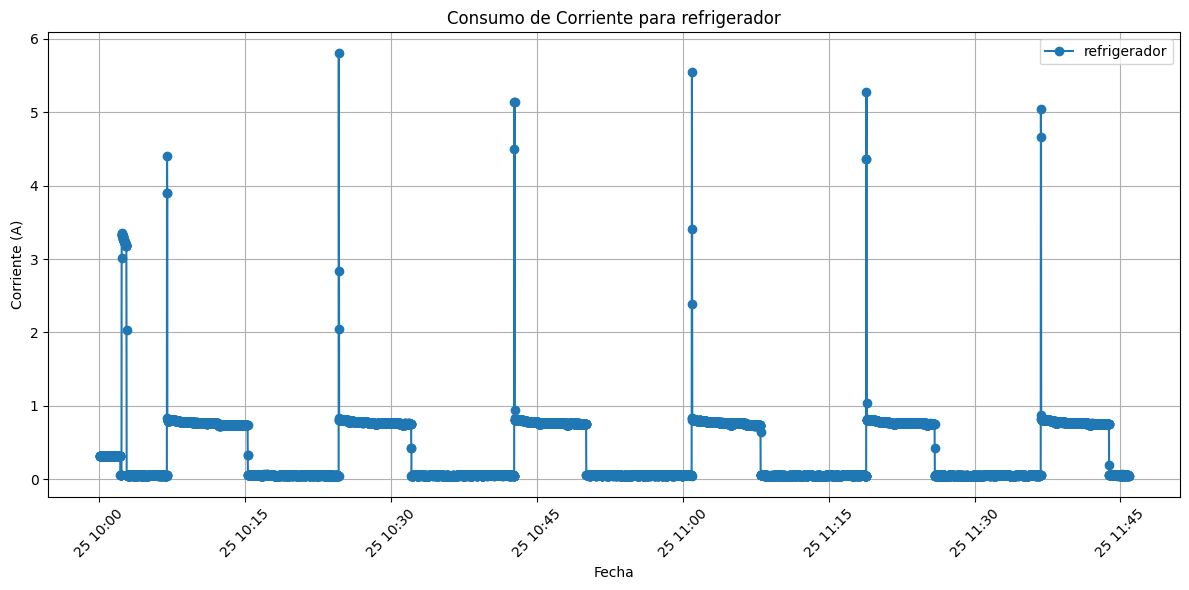

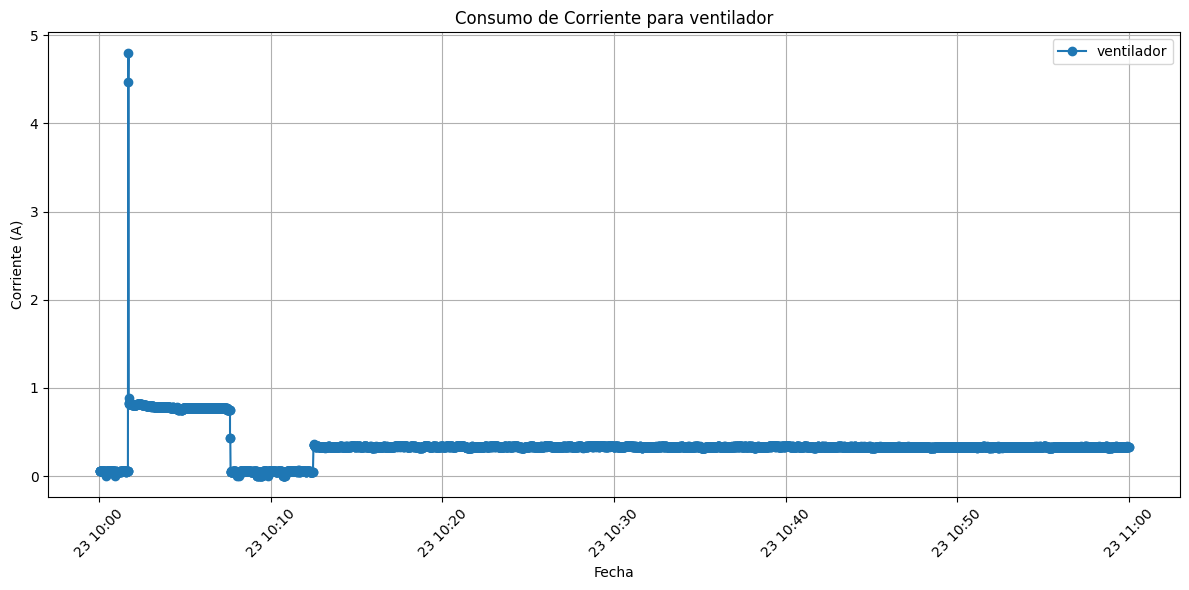

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que la columna 'fecha' sea de tipo datetime
datos_combinados['fecha'] = pd.to_datetime(datos_combinados['fecha'])

# Graficar por cada dispositivo
for dispositivo in datos_combinados['dispositivo'].unique():
    subset = datos_combinados[datos_combinados['dispositivo'] == dispositivo]
    
    # Crear una nueva figura para cada gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(subset['fecha'], subset['Corriente_linea1'], marker='o', linestyle='-', label=dispositivo)
    
    # Etiquetas y título
    plt.xlabel('Fecha')
    plt.ylabel('Corriente (A)')
    plt.title(f'Consumo de Corriente para {dispositivo}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()  # Mostrar la gráfica


COMENZAMOS CON EL ENTRENAMIENTO

Para este punto iniciaremos extrayendo características de cada datos considerando:
media, desviación, corriente_max, corriente_min

In [3]:
#EXTRACCION DE CARACTERISTICAS DE CADA DISPOSITIVO, MEDIA, DESVIACION Y PICOS

# Calcular características estadísticas de corriente
def extraer_caracteristicas(df):
    df['media_corriente'] = df['Corriente_linea1'].rolling(window=5).mean()  # Media en una ventana de 5 muestras
    df['desviacion_corriente'] = df['Corriente_linea1'].rolling(window=5).std()  # Desviación estándar
    df['corriente_max'] = df['Corriente_linea1'].rolling(window=5).max()  # Corriente máxima
    df['corriente_min'] = df['Corriente_linea1'].rolling(window=5).min()  # Corriente mínima
    df = df.dropna()  # Elimina valores NaN generados por la ventana de tiempo
    return df

# Aplicar la extracción de características
datos_combinados = extraer_caracteristicas(datos_combinados)

# Selección de características y etiquetas
X = datos_combinados[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
y = datos_combinados['dispositivo']

Aqui dividimos los datos en donde el 80% será solo para entrenamiento con el Random Forest
y el otro 20% de prueba es decir que será una muestra para evaluar el rendimiento del modelo y verificar su capacidad de generalización en datos no vistos

In [4]:
#DIVISION DE DATOS

from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

EN ESTE PUNTO INICIA COMO EL ENTRENAMIENTO, AQUI GENERA LOS DATOS DE PREDICCION EN UN NUEVO CSV
Y DESPUÉS LOS INTERPRETARA EN NUESTROS DATOS GENERALES

Los datos generales son las mediciones generales de los dispositivos los cuales se encuenntran en la Carpeta Datos_generales


In [5]:
#ENTRENAMIENTO DEL MODELO RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


variable = 'Corriente_linea1'
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#PREDICCION CON NUEVOS DATOS

# Cargar nuevos datos
datos_generales = pd.read_csv(f"Datos_generales_{variable}.csv")

# Extraer características
datos_generales = extraer_caracteristicas(datos_generales)

# Predecir el dispositivo de cada registro
X_nuevos = datos_generales[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame
datos_generales['dispositivo_predicho'] = predicciones

# Guardar los resultados en un archivo CSV
datos_generales.to_csv('Predicciones.csv', index=False)#VISUALIZACION


[[1525   22]
 [  93  806]]
              precision    recall  f1-score   support

refrigerador       0.94      0.99      0.96      1547
  ventilador       0.97      0.90      0.93       899

    accuracy                           0.95      2446
   macro avg       0.96      0.94      0.95      2446
weighted avg       0.95      0.95      0.95      2446



VISUALIZACIÓN DE CORRIENTE REAL

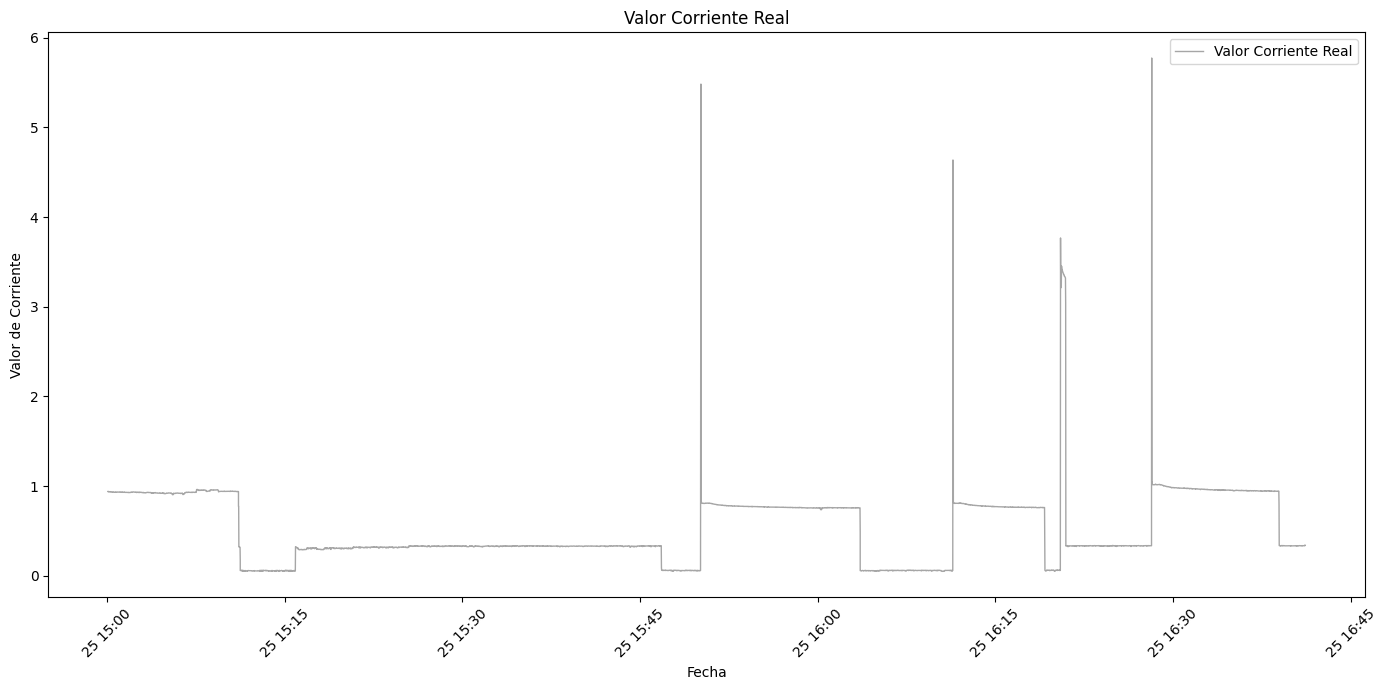

In [6]:
import matplotlib.pyplot as plt

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))


if not isinstance(datos_generales['fecha'], pd.DatetimeIndex):
    datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Valor Corriente Real')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()

PRIMERA VISUALIZACIÓN DE LAS PREDICCIONES CON VALORES REALES

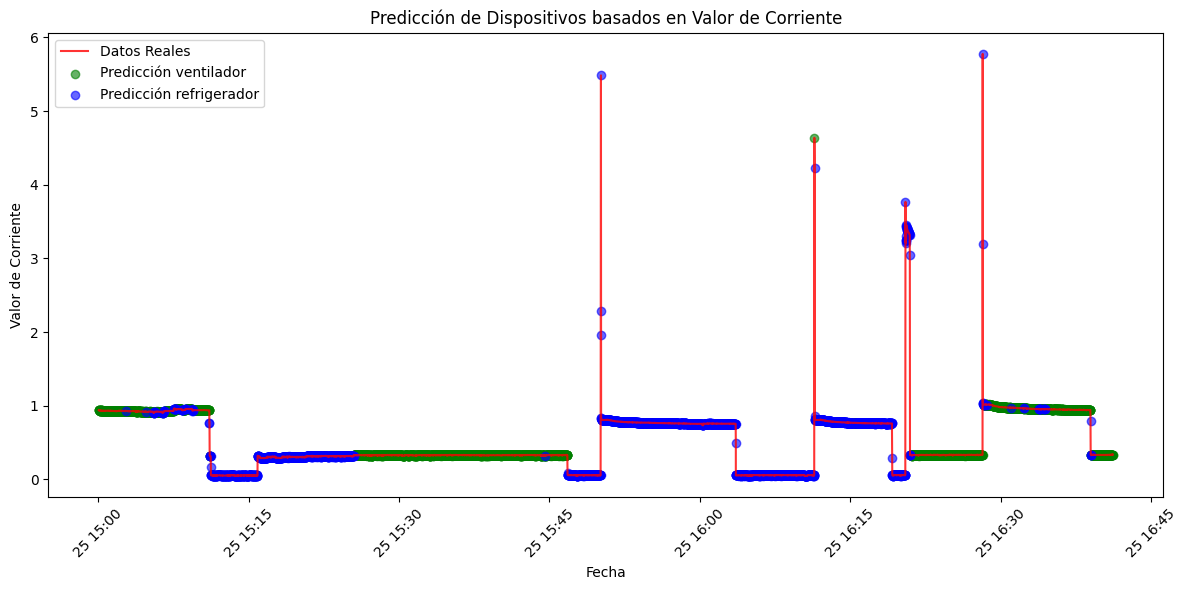

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'green'}

# Asegurarse de que la columna 'fecha' esté en formato datetime
if not isinstance(datos_generales['fecha'], pd.DatetimeIndex):
    datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Establecer la columna 'fecha' como índice si aún no lo está
if datos_generales.index.name != 'fecha':
    datos_generales.set_index('fecha', inplace=True)

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))

# Graficar los datos reales como una línea continua
plt.plot(datos_generales.index, datos_generales['Corriente_linea1'], label='Datos Reales', color='red', alpha=0.8)

# Graficar la predicción de dispositivos como puntos
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.scatter(subset.index, subset['Corriente_linea1'], label=f'Predicción {dispositivo}', color=colores.get(dispositivo, 'black'), alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos basados en Valor de Corriente')
plt.xticks(rotation=45)
plt.legend()

# Ajustar y mostrar la gráfica
plt.tight_layout()
plt.show()


Segregación

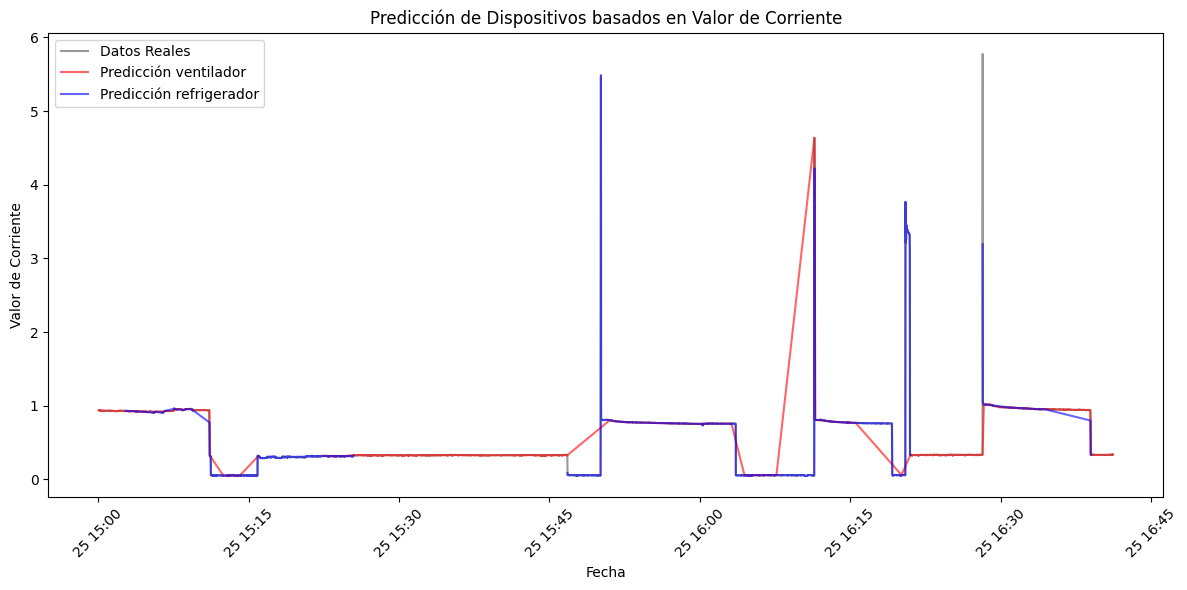

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'red'}

# Asegurarse de que la columna 'fecha' esté en formato datetime
if 'fecha' in datos_generales.columns:
    if not isinstance(datos_generales['fecha'], pd.DatetimeIndex):
        datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Establecer la columna 'fecha' como índice
    datos_generales.set_index('fecha', inplace=True)

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))

# Graficar los datos reales como una línea continua
plt.plot(datos_generales.index, datos_generales['Corriente_linea1'], label='Datos Reales', color='gray', alpha=0.8)

# Umbral de discontinuidad (por ejemplo, 5 minutos)
umbral_discontinuidad = pd.Timedelta('5min')

# Graficar la predicción de dispositivos como líneas discontinuas
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo].copy()

    # Calcular la diferencia de tiempo entre las filas
    subset['diff'] = subset.index.to_series().diff()

    # Introducir NaN donde la diferencia de tiempo es mayor que el umbral
    subset.loc[subset['diff'] > umbral_discontinuidad, 'Corriente_linea1'] = np.nan
    
    # Graficar las predicciones como líneas con discontinuidades (NaN introducidos)
    plt.plot(subset.index, subset['Corriente_linea1'], label=f'Predicción {dispositivo}', color=colores.get(dispositivo, 'black'), alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos basados en Valor de Corriente')
plt.xticks(rotation=45)
plt.legend()

# Ajustar y mostrar la gráfica
plt.tight_layout()
plt.show()


VISUALIZACIÓN POR COMPORTAMIENTO DE CADA DISPOSITIVO

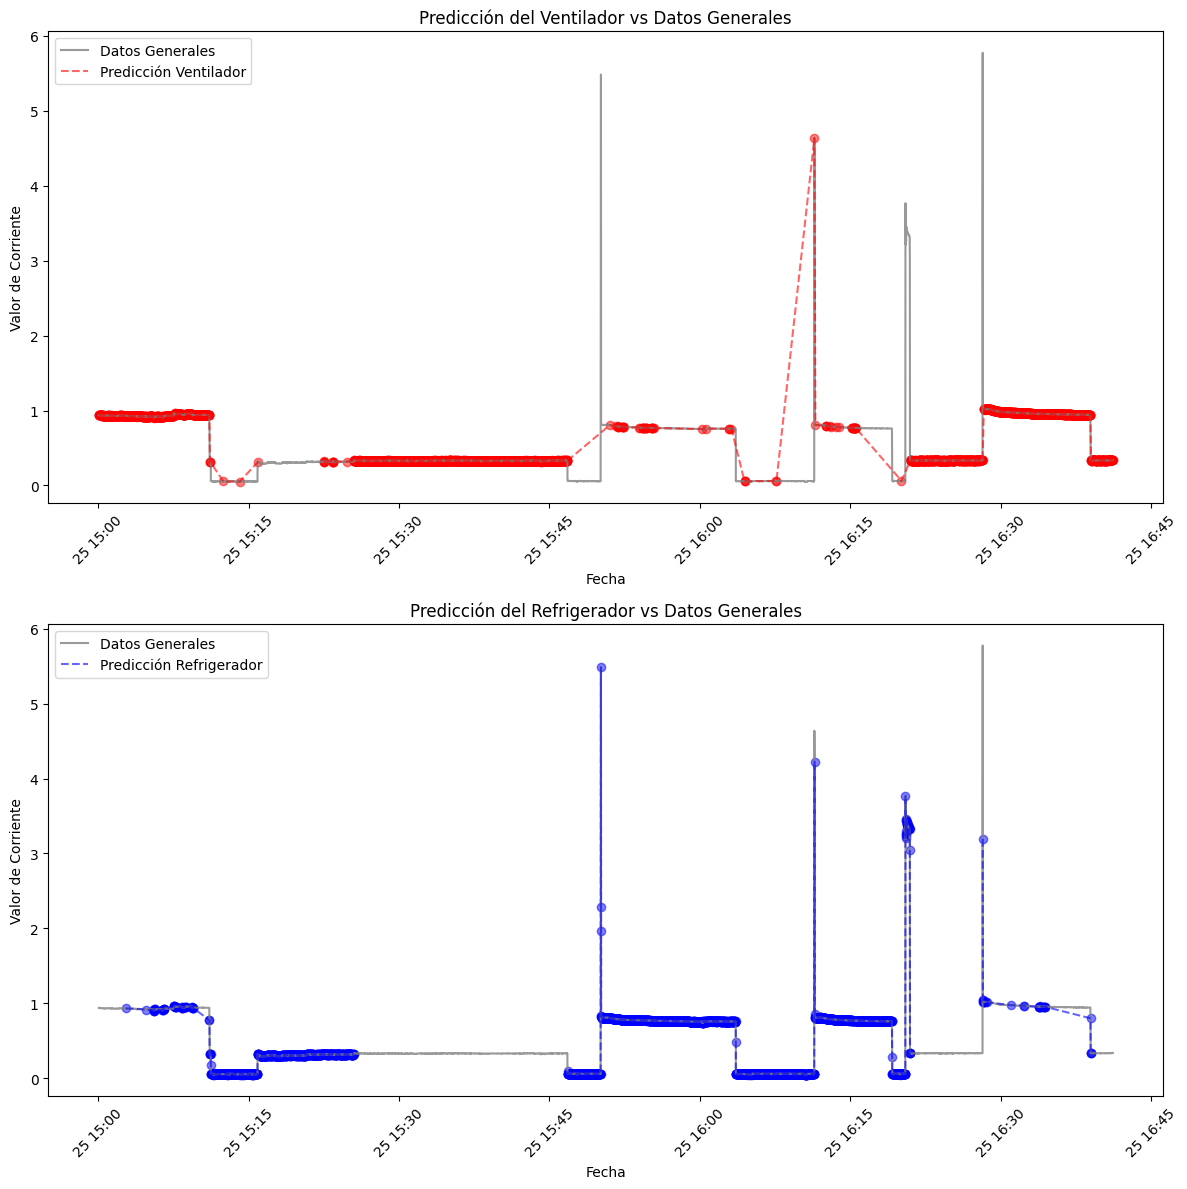

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'red'}

# Asegurarse de que la columna 'fecha' esté en formato datetime
if 'fecha' in datos_generales.columns:
    if not isinstance(datos_generales['fecha'], pd.DatetimeIndex):
        datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Establecer la columna 'fecha' como índice
    datos_generales.set_index('fecha', inplace=True)

# Crear subgráficas
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Graficar datos generales en ambas subgráficas
axs[0].plot(datos_generales.index, datos_generales['Corriente_linea1'], label='Datos Generales', color='gray', alpha=0.8)
axs[1].plot(datos_generales.index, datos_generales['Corriente_linea1'], label='Datos Generales', color='gray', alpha=0.8)

# Umbral de discontinuidad (por ejemplo, 5 minutos)
umbral_discontinuidad = pd.Timedelta('5min')

# Graficar el ventilador
ventilador_subset = datos_generales[datos_generales['dispositivo_predicho'] == 'ventilador'].copy()
ventilador_subset['diff'] = ventilador_subset.index.to_series().diff()
ventilador_subset.loc[ventilador_subset['diff'] > umbral_discontinuidad, 'Corriente_linea1'] = np.nan

# Graficar los datos del ventilador
axs[0].plot(ventilador_subset.index, ventilador_subset['Corriente_linea1'], label='Predicción Ventilador', color='red', linestyle='--', alpha=0.6)
axs[0].scatter(ventilador_subset.index, ventilador_subset['Corriente_linea1'], color='red', alpha=0.5)

# Configurar etiquetas y título para la gráfica del ventilador
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Valor de Corriente')
axs[0].set_title('Predicción del Ventilador vs Datos Generales')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Graficar el refrigerador
refrigerador_subset = datos_generales[datos_generales['dispositivo_predicho'] == 'refrigerador'].copy()
refrigerador_subset['diff'] = refrigerador_subset.index.to_series().diff()
refrigerador_subset.loc[refrigerador_subset['diff'] > umbral_discontinuidad, 'Corriente_linea1'] = np.nan

# Graficar los datos del refrigerador
axs[1].plot(refrigerador_subset.index, refrigerador_subset['Corriente_linea1'], label='Predicción Refrigerador', color='blue', linestyle='--', alpha=0.6)
axs[1].scatter(refrigerador_subset.index, refrigerador_subset['Corriente_linea1'], color='blue', alpha=0.5)

# Configurar etiquetas y título para la gráfica del refrigerador
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor de Corriente')
axs[1].set_title('Predicción del Refrigerador vs Datos Generales')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

# Ajustar y mostrar las gráficas
plt.tight_layout()
plt.show()


VISUALIZACIÓN RESULTADOS PREDICCION VS REAL

Como se puede observar las línea ---- son las predicciones y donde está pintado de buena manera es la exactitud

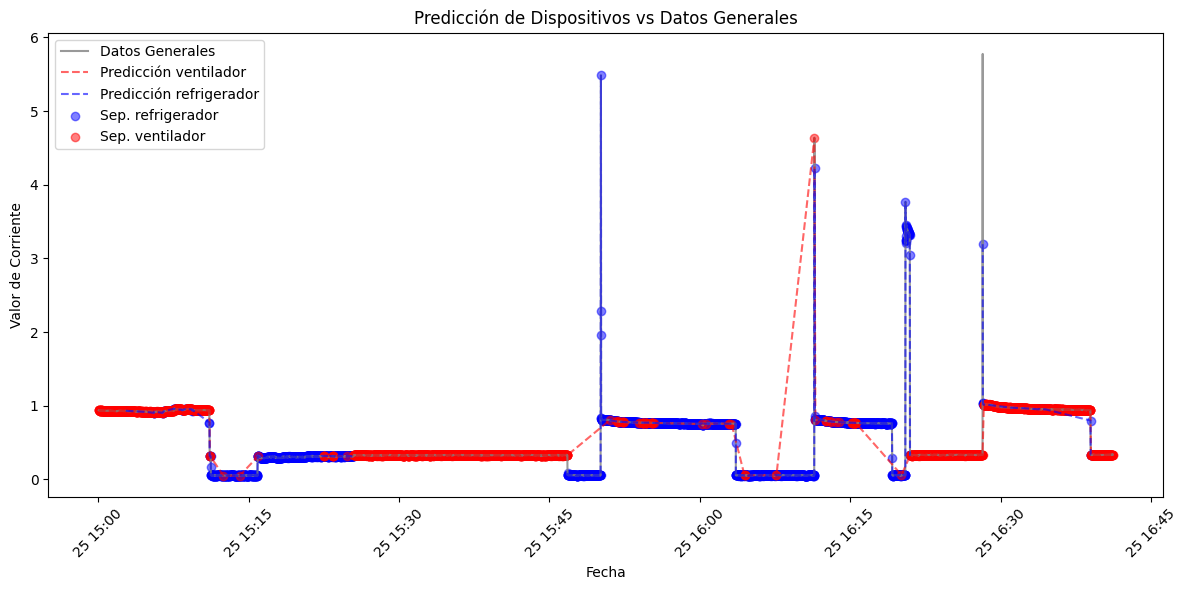

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'red'}

# Asegurarse de que la columna 'fecha' esté en formato datetime
if 'fecha' in datos_generales.columns:
    if not isinstance(datos_generales['fecha'], pd.DatetimeIndex):
        datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Establecer la columna 'fecha' como índice
    datos_generales.set_index('fecha', inplace=True)

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))

# Graficar los datos generales como una línea continua
plt.plot(datos_generales.index, datos_generales['Corriente_linea1'], label='Datos Generales', color='gray', alpha=0.8)

# Umbral de discontinuidad (por ejemplo, 5 minutos)
umbral_discontinuidad = pd.Timedelta('5min')

# Graficar la predicción de dispositivos como líneas discontinuas
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo].copy()

    # Calcular la diferencia de tiempo entre las filas
    subset['diff'] = subset.index.to_series().diff()

    # Introducir NaN donde la diferencia de tiempo es mayor que el umbral
    subset.loc[subset['diff'] > umbral_discontinuidad, 'Corriente_linea1'] = np.nan
    
    # Graficar las predicciones como líneas con discontinuidades (NaN introducidos)
    plt.plot(subset.index, subset['Corriente_linea1'], label=f'Predicción {dispositivo}', color=colores.get(dispositivo, 'black'), linestyle='--', alpha=0.6)

# Separar los dispositivos en gráficos individuales
for dispositivo in ['refrigerador', 'ventilador']:
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo].copy()

    # Calcular la diferencia de tiempo entre las filas
    subset['diff'] = subset.index.to_series().diff()

    # Introducir NaN donde la diferencia de tiempo es mayor que el umbral
    subset.loc[subset['diff'] > umbral_discontinuidad, 'Corriente_linea1'] = np.nan
    
    # Graficar los datos separados para cada dispositivo
    plt.scatter(subset.index, subset['Corriente_linea1'], color=colores[dispositivo], alpha=0.5, label=f'Sep. {dispositivo}')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos vs Datos Generales')
plt.xticks(rotation=45)
plt.legend()

# Ajustar y mostrar la gráfica
plt.tight_layout()
plt.show()
